In [3]:
cd ../../

/home/novella/PycharmProjects/stock-price-trend-prediction-remote-matteo


In [211]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import MeanShift, KMeans
import numpy as np
import pickle

import src.utils.lob_util as lbu
import src.config as co

np.random.seed(0)
plt.rcParams["figure.figsize"] = (16,9)

print(os.getcwd())

/home/novella/PycharmProjects/stock-price-trend-prediction-remote-matteo


In [212]:
PATH_NAME = "data/LOBSTER_6/unzipped/"
STOCKS_FNAME = ["_data_dwn_48_332__{}_2021-07-01_2021-08-06_10", "_data_dwn_48_332__{}_2020-03-01_2020-04-03_10"]
STOCKS_PAIRS = [("AAPL", "NVDA"), ("ZM", "AAWW"), ("AGNC", "LYFT")]
STOCKS = ["AAPL", "TSLA", "ZM", "AAWW", "AGNC", "LYFT"]

In [251]:
scenarios = [0, 1]
mids = {0:None, 1:None}
for scen in scenarios:
    daily_midprice = pd.DataFrame()
    RETURNS_FNAME = "data/LOBSTER_6/price_return_df_5_scen{}.dat".format(scen)

    if not os.path.exists(RETURNS_FNAME):

        for i, i_stock in enumerate(STOCKS):
            print("Processing stock", i, i_stock)

            stock_path = PATH_NAME + STOCKS_FNAME[scen].format(i_stock)
                
            tra_days = os.listdir(stock_path)
            tra_days.sort()

            out_df = lbu.from_folder_to_unique_df(
                stock_path,
                level=10,
                granularity=co.Granularity.Sec1,
                boundaries_purge=0
            )
            out_df = out_df.fillna(method="ffill")
            daily_midprice[i_stock] = (out_df.loc[:, "psell1"] + out_df.loc[:, "pbuy1"]) / (2 * 10000)
            
            print("HAS CORRECT SHAPE?", out_df.shape[0], out_df.shape[0] == 60*60*6.5*25)
            out_df = None
        
        mids[scen] = daily_midprice
        
        with open(RETURNS_FNAME, "wb") as f:
             pickle.dump(daily_midprice, f)
    else:
        print("Loading pickle...")
        with open(RETURNS_FNAME, "rb") as f:
            daily_midprice = pickle.load(f)
        
        mids[scen] = daily_midprice

Loading pickle...
Loading pickle...


In [320]:
daily_midprice = mids[1]
daily_midprice.shape[0] == 60*60*6.5*25

True

In [321]:
daily_midprice

,AAPL,TSLA,ZM,AAWW,AGNC,LYFT
date,,,,,,
2020-03-02 09:30:00,282.270,711.600,109.615,26.725,17.390,38.450
2020-03-02 09:30:01,282.405,712.385,109.575,27.000,17.280,38.495
2020-03-02 09:30:02,282.345,712.470,109.395,27.150,17.255,38.450
2020-03-02 09:30:03,282.390,713.790,109.400,26.880,17.225,38.465
2020-03-02 09:30:04,283.145,714.430,109.425,27.100,17.240,38.430
...,...,...,...,...,...,...
2020-04-03 15:59:55,241.455,479.395,128.005,20.160,9.505,22.025
2020-04-03 15:59:56,241.465,479.540,128.005,20.155,9.515,22.025
2020-04-03 15:59:57,241.420,479.395,128.100,20.155,9.515,22.025


In [322]:
GRANULARITY = int(60*60*6.5)
day = 11
daily_midprice[GRANULARITY*day:GRANULARITY*(day+1)]

,AAPL,TSLA,ZM,AAWW,AGNC,LYFT
date,,,,,,
2020-03-17 09:30:00,247.445,439.995,107.590,19.745,12.355,19.450
2020-03-17 09:30:01,247.390,440.090,107.400,19.145,12.090,19.410
2020-03-17 09:30:02,247.425,440.275,107.475,19.145,12.090,19.380
2020-03-17 09:30:03,247.795,440.565,107.135,19.160,12.090,19.305
2020-03-17 09:30:04,247.655,440.540,107.140,19.165,12.090,19.305
...,...,...,...,...,...,...
2020-03-17 15:59:55,252.690,429.775,111.045,23.530,11.775,18.705
2020-03-17 15:59:56,252.625,429.485,111.065,23.530,11.800,18.650
2020-03-17 15:59:57,252.635,429.570,111.065,23.560,11.810,18.635


In [323]:
GRANULARITY = int(60*30)
daily_midprice = daily_midprice.iloc[::GRANULARITY, :]  # 2. samples days granularity
daily_midprice = daily_midprice.dropna(axis=0)          # 1. removes days that are not traded
daily_midprice = daily_midprice[daily_midprice != 0]

daily_midprice.index = daily_midprice.index.map(str)
daily_midprice_norm = daily_midprice / daily_midprice.iloc[0, :]

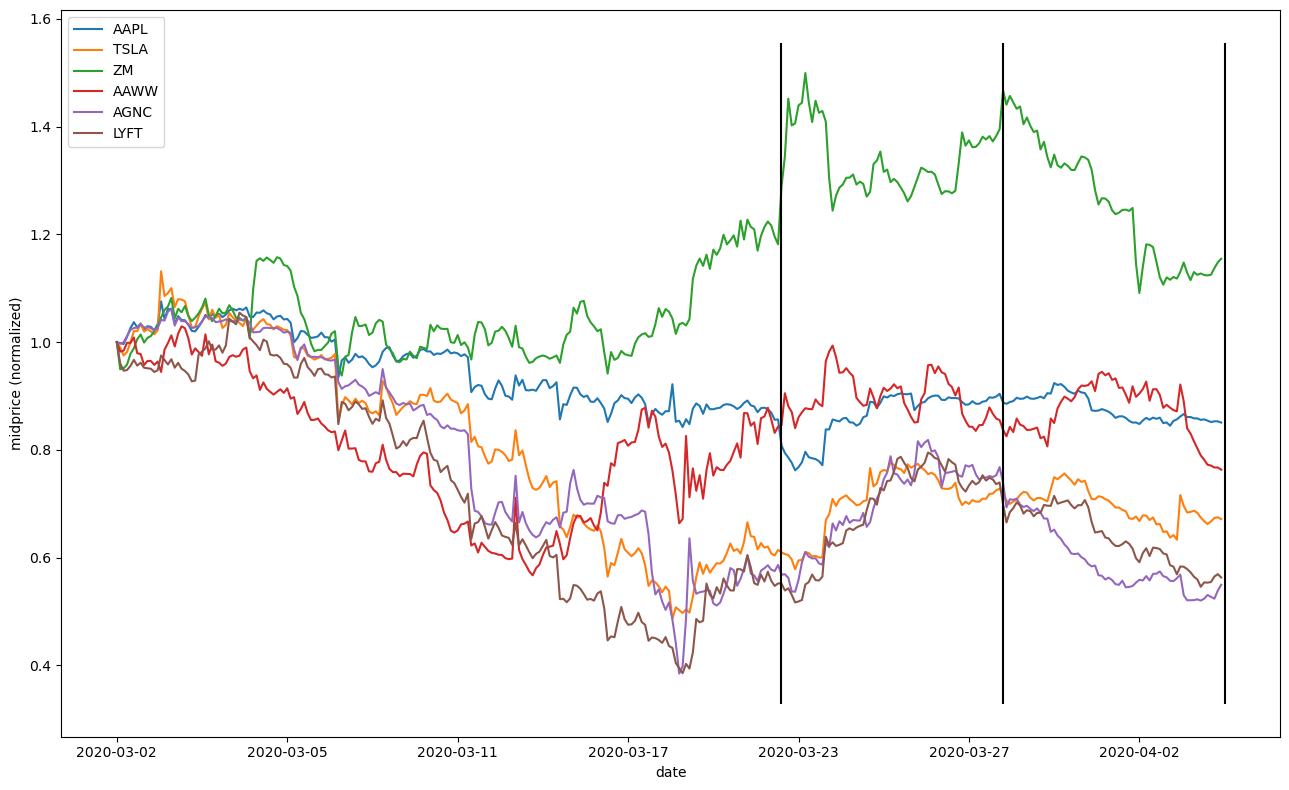

In [324]:
daily_midprice_norm.index = [ind.split(" ")[0] for ind in daily_midprice_norm.index]
x_axis = list(daily_midprice_norm.index)
fig, ax = plt.subplots(figsize=(13, 8))

ax = daily_midprice_norm.plot(ax = ax)

# SCEWNARIO = ('2021-07-22', '2021-07-29', '2021-08-06')
SCEWNARIO = ('2020-03-20', '2020-03-27', '2020-04-03')
yli = ax.get_ylim()
ax.vlines(x=x_axis.index(SCEWNARIO[0])+13, ymin=yli[0], ymax=yli[1], color='black') # 13 mezz'ore in 6.5 ore
ax.vlines(x=x_axis.index(SCEWNARIO[1])+13, ymin=yli[0], ymax=yli[1], color='black')
ax.vlines(x=x_axis.index(SCEWNARIO[2])+13, ymin=yli[0], ymax=yli[1], color='black')
# plt.xticks(rotation=10)

plt.ylabel("midprice (normalized)")
plt.xlabel("date")

ax.legend(loc='upper left')
plt.tight_layout()
fig.savefig('scenario-mar.pdf', dpi=400)

In [119]:
daily_midprice = daily_midprice[daily_midprice != 0]

past_mid = daily_midprice[:-1]
futu_mid = daily_midprice.shift(-1)[:-1]
daily_returns_df = (futu_mid - past_mid) / past_mid
daily_returns_df = daily_returns_df[-10 < daily_returns_df]
daily_returns_df = daily_returns_df[ 10 > daily_returns_df]
daily_returns_df

,AAPL,NVDA,ZM,AAWW,AGNC,LYFT
date,,,,,,
2021-07-01 09:30:00,0.001428,0.007520,-0.003891,-0.005230,-0.000591,-0.001225
2021-07-01 09:31:00,-0.001206,0.002083,-0.001155,0.000292,-0.000887,-0.001962
2021-07-01 09:32:00,0.002013,0.000855,0.002572,-0.003869,-0.000592,-0.001638
2021-07-01 09:33:00,-0.000110,-0.001991,0.001827,-0.000293,-0.001776,-0.000246
2021-07-01 09:34:00,-0.001352,-0.000308,-0.002781,-0.003005,-0.000593,0.001559
...,...,...,...,...,...,...
2021-08-06 15:54:00,0.000342,0.000123,0.000248,-0.000069,0.000626,-0.000191
2021-08-06 15:55:00,-0.000342,0.000270,0.000117,0.000965,0.000000,-0.001143
2021-08-06 15:56:00,0.000000,-0.000417,-0.000690,0.000896,0.000000,0.000191


In [120]:
# WIN = 20
# stds_df = daily_returns_df.rolling(WIN).std()
# #avgs_df = daily_returns_df.rolling(WIN).mean()
# # ax = daily_returns_df.plot()
# # stds_df.plot(ax=ax)
# stds_df.iloc[:, 10:50].plot()

In [121]:
risk_return = pd.DataFrame()
risk_return["return"] = daily_returns_df.mean(axis=0)
risk_return["risk"] = daily_returns_df.std(axis=0)
# risk_return = risk_return.drop("ALHC")
risk_return

,return,risk
AAPL,7.138744e-06,0.000729
NVDA,-7.492120e-05,0.007695
ZM,5.025054e-08,0.001375
AAWW,6.643118e-06,0.001468
AGNC,-5.564314e-06,0.000725
LYFT,-1.446337e-05,0.001659


In [122]:
fig = px.scatter(risk_return, x='return', y='risk', text=risk_return.index)
fig.show()